In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:

#Initilize classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
#create a dataset from tensors.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

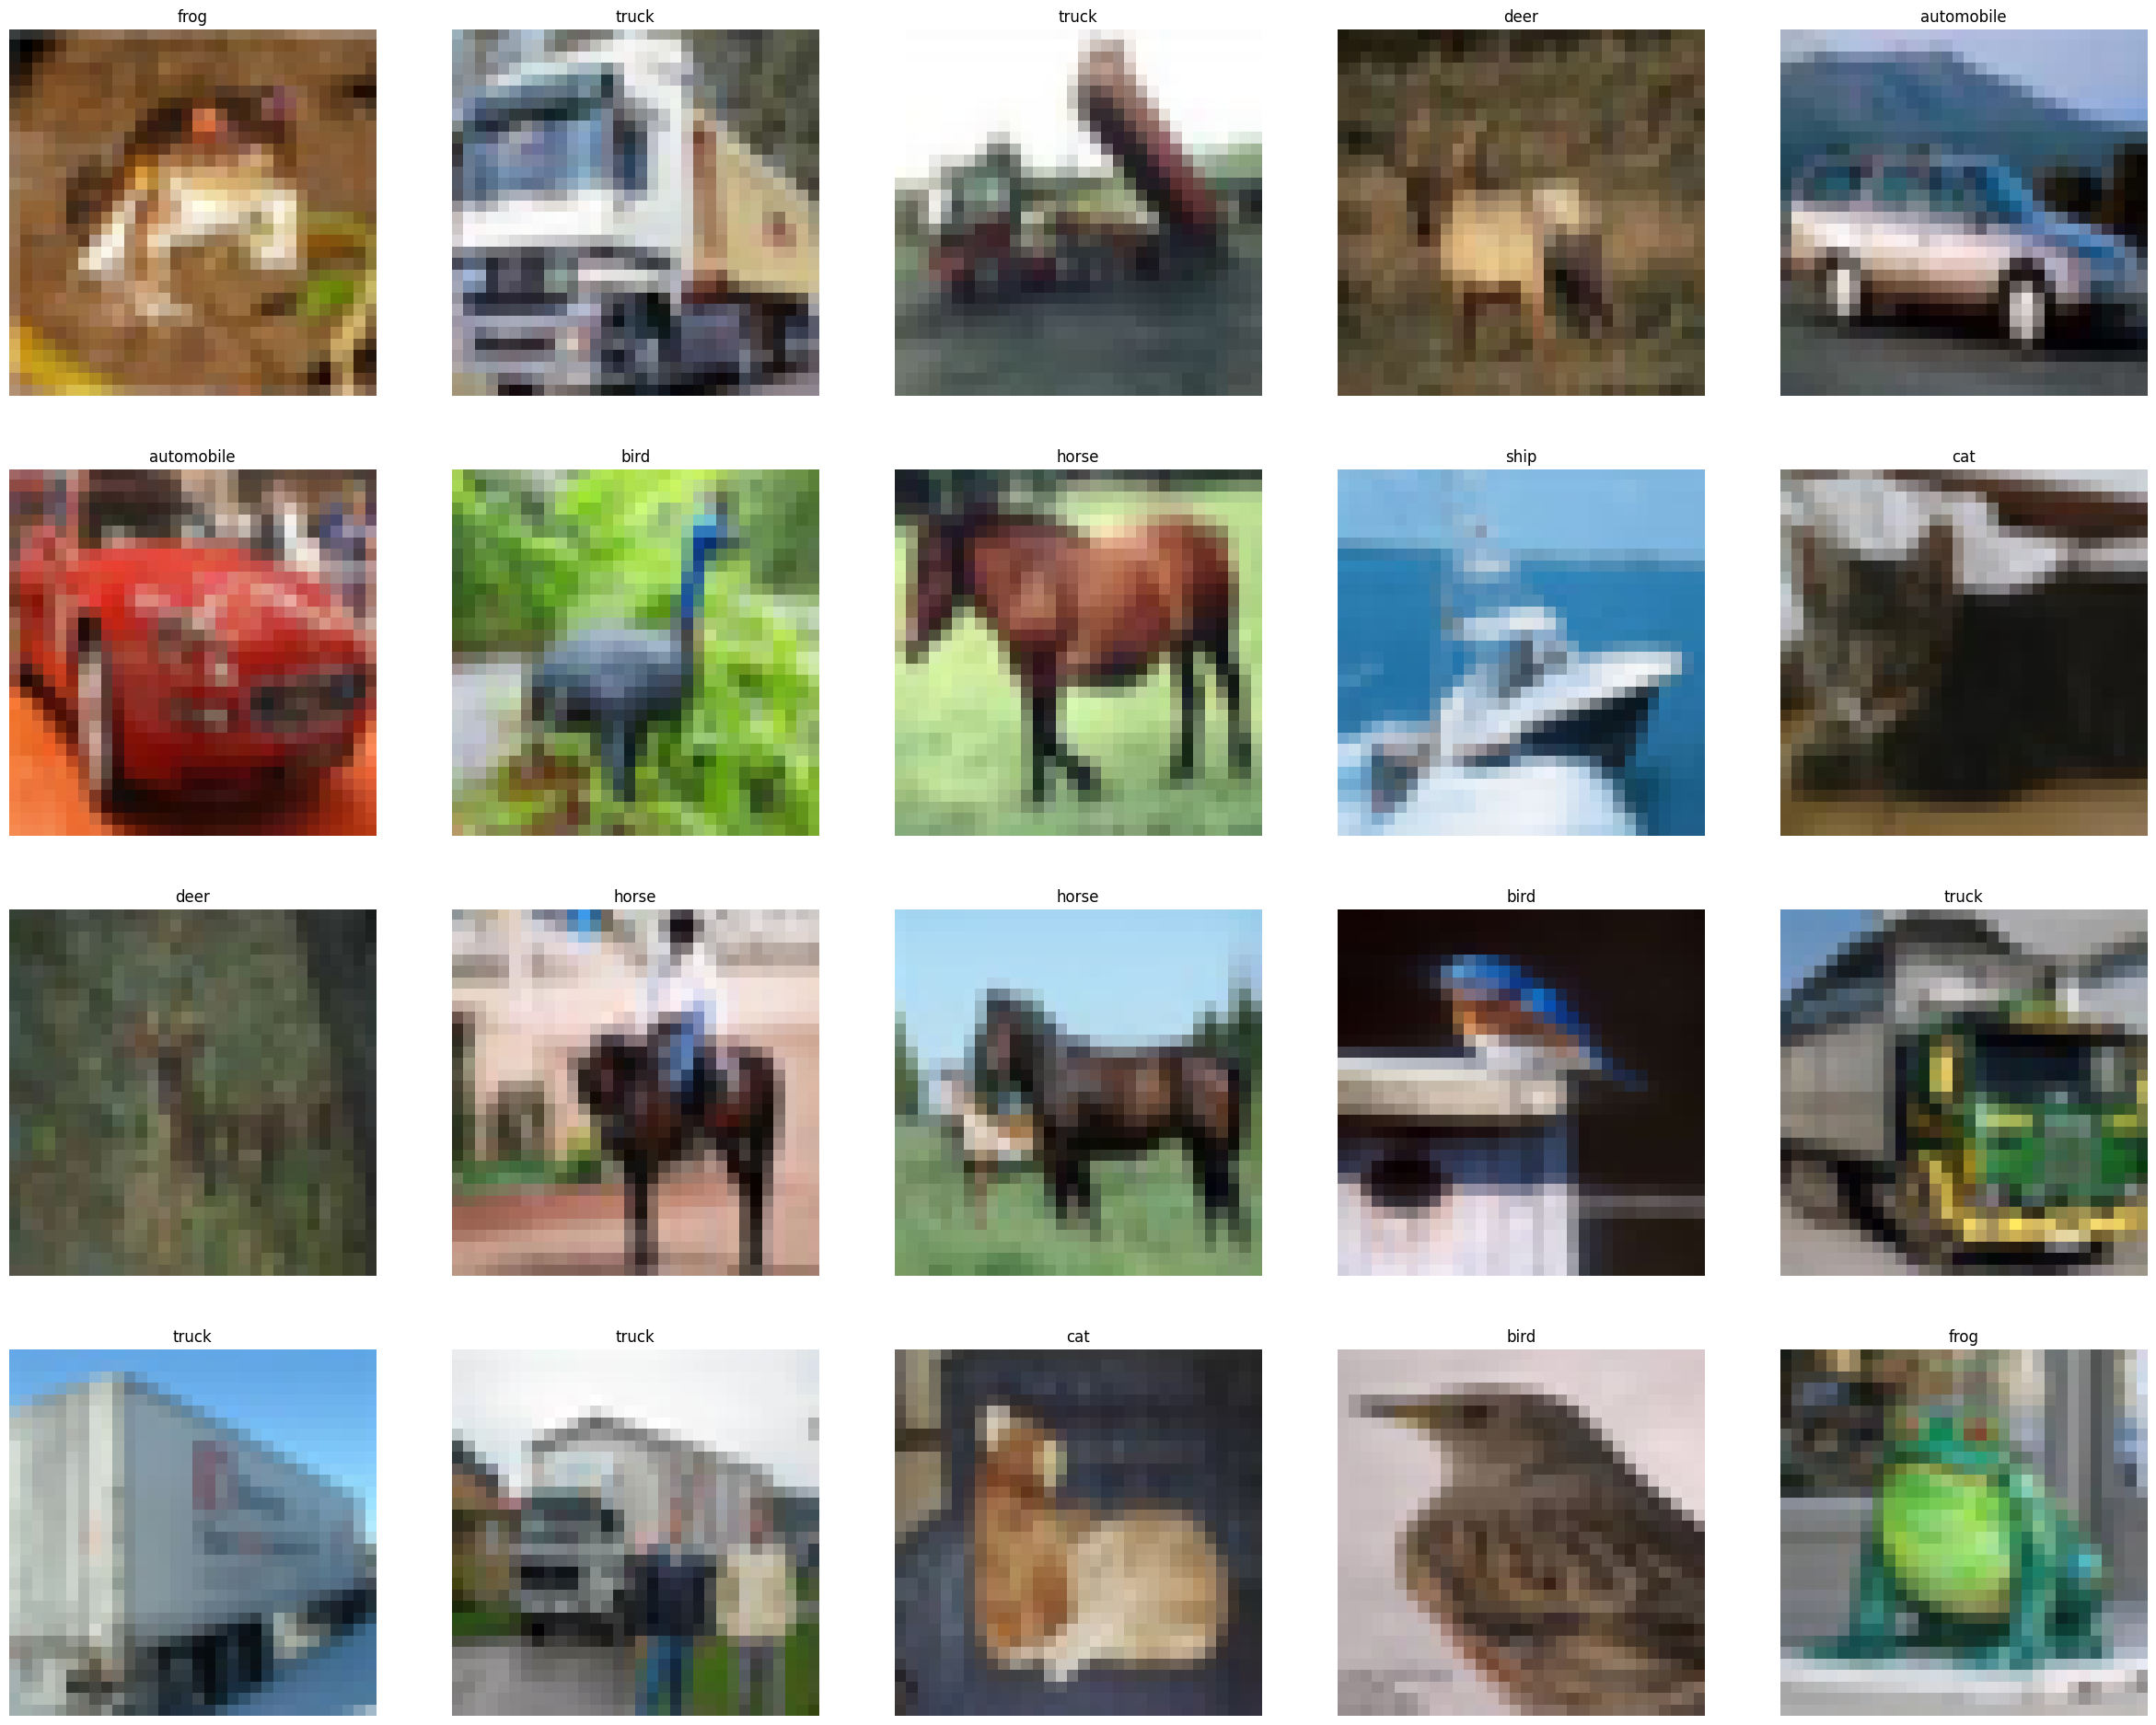

In [5]:
#visualize the images within the CIFAR-10 dataset.
plt.figure(figsize=(30, 30))
for i, (image, label) in enumerate(train_ds.take(20)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy())  # Convert TensorFlow tensor to numpy array
    plt.title(classes[label.numpy()[0]])
    plt.axis('off')
plt.show()

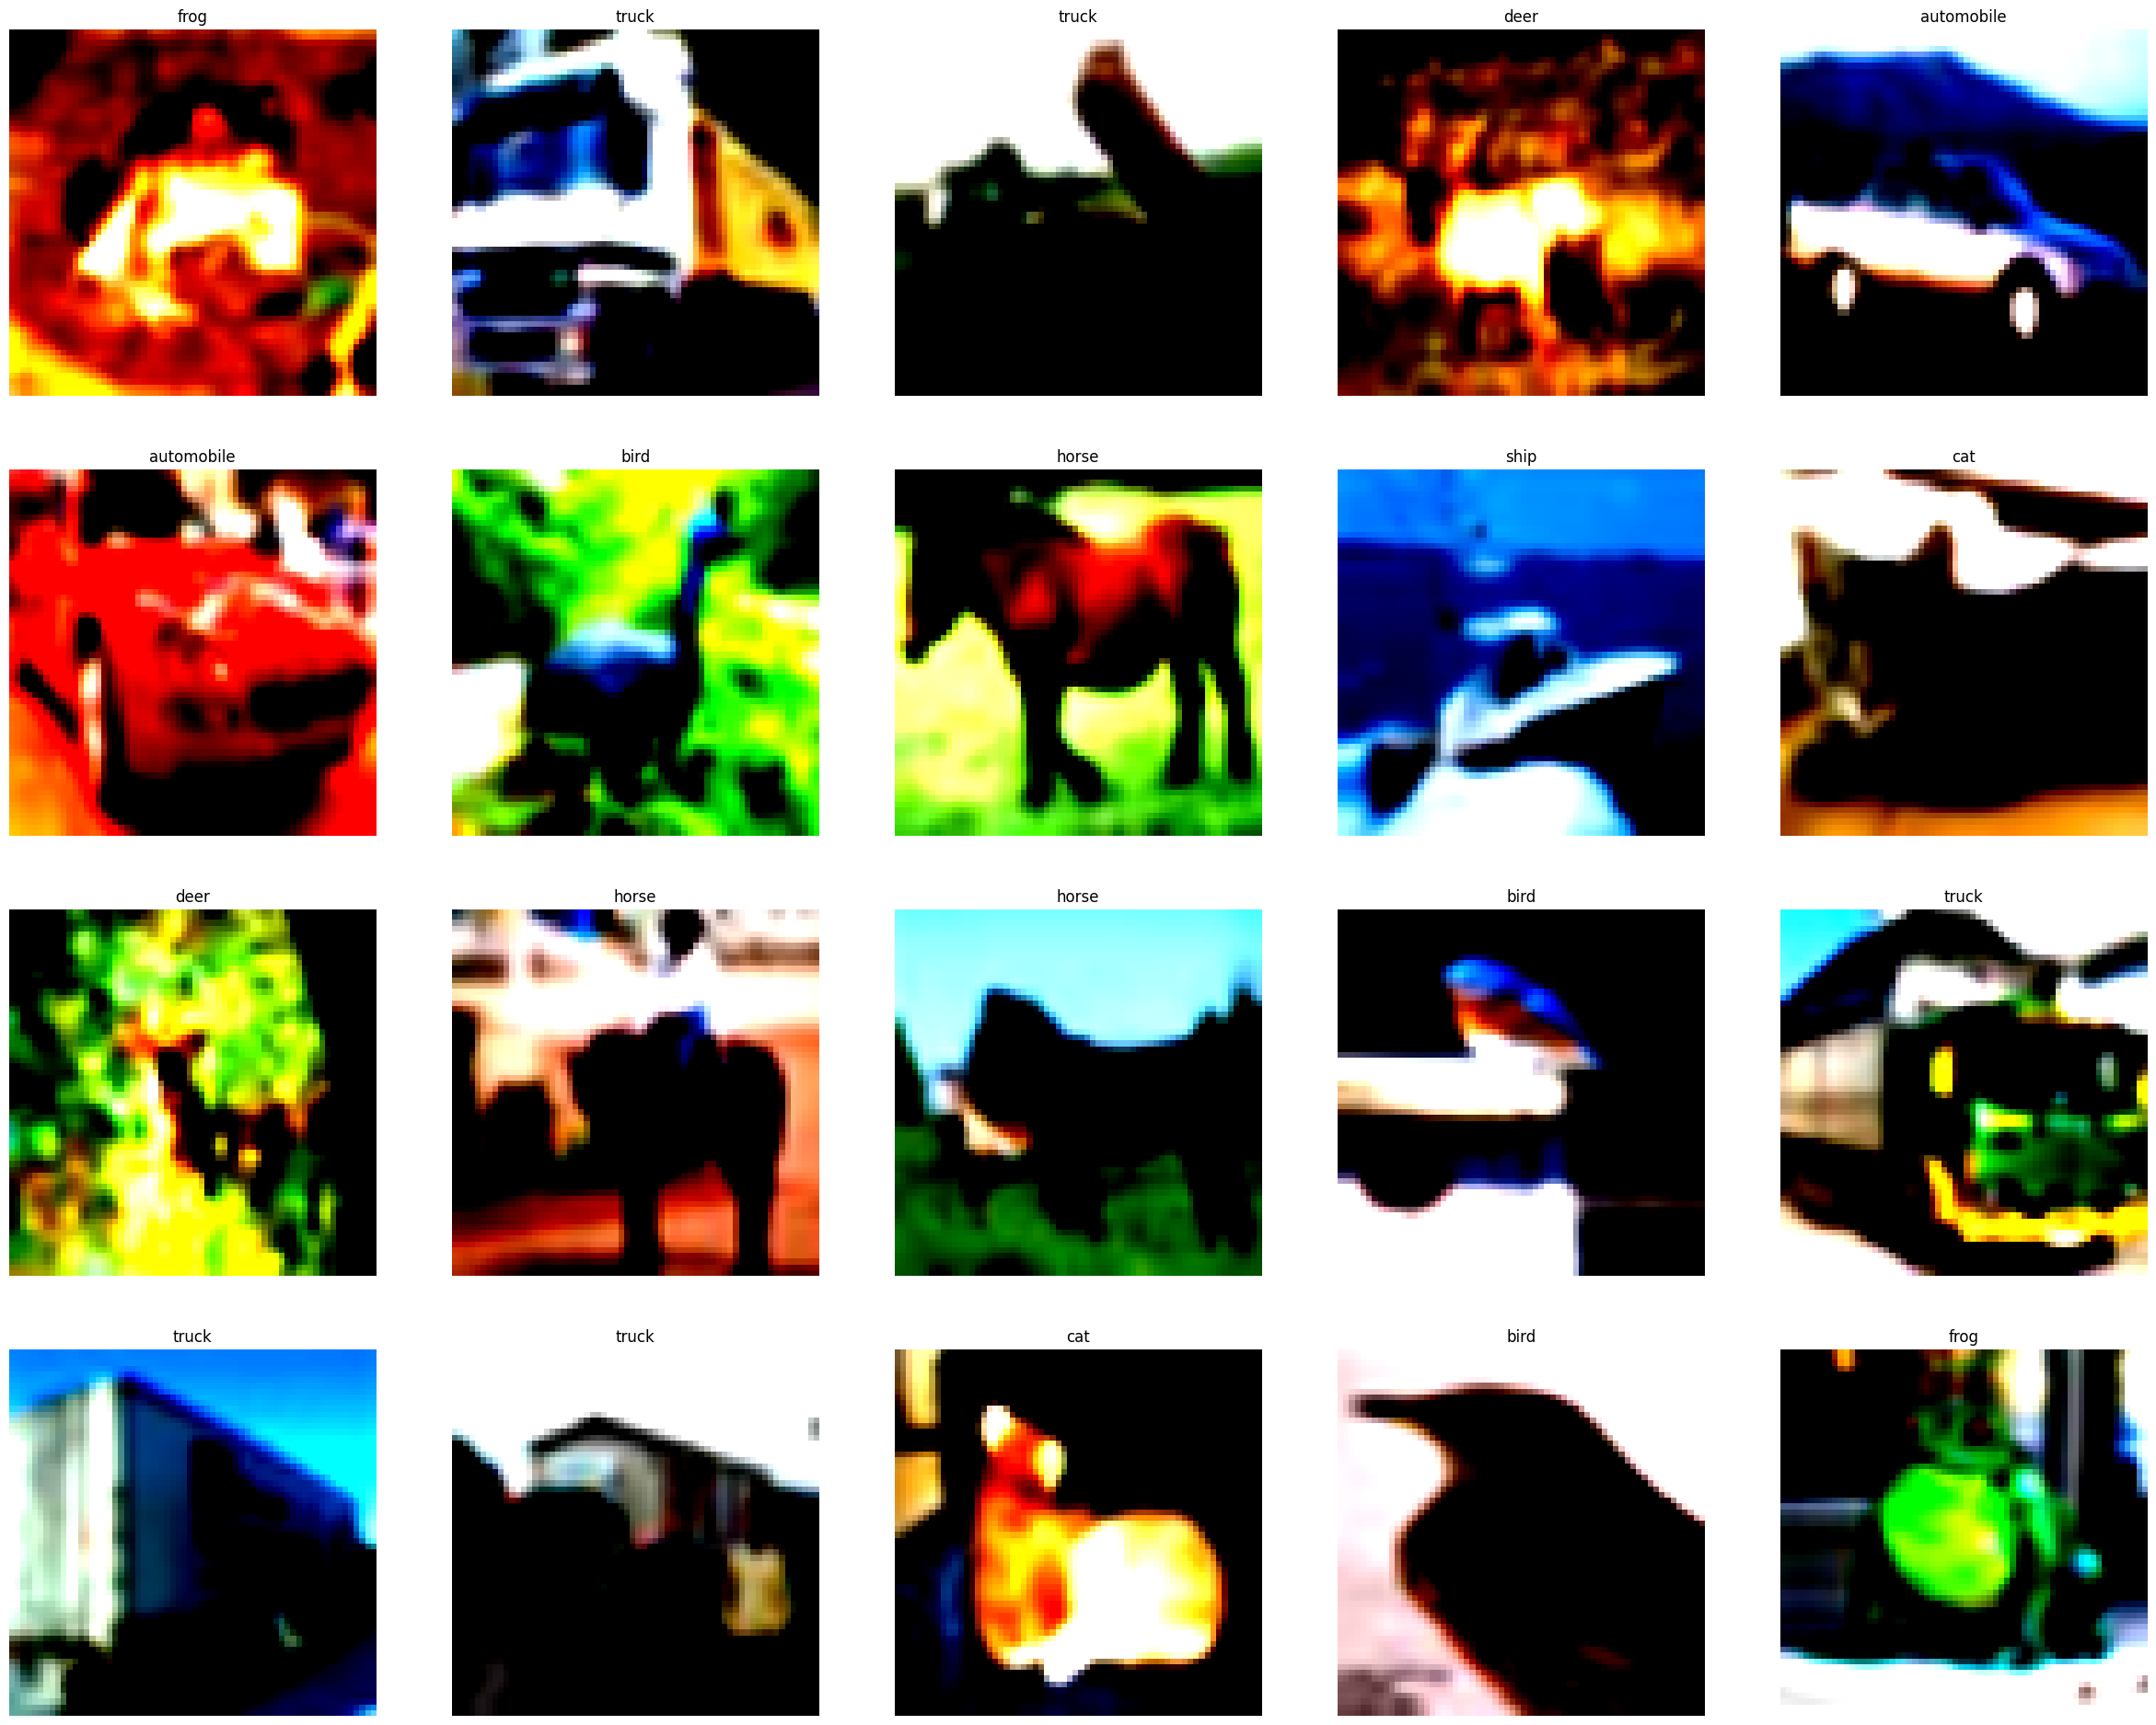

In [6]:
# Define process_image function
def process_image(image, label):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (64, 64))
    return image, label

# Apply process_image function to the dataset
processed_train_ds = train_ds.map(process_image)

# Plotting the processed images
plt.figure(figsize=(30, 30))
for i, (image, label) in enumerate(processed_train_ds.take(20)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy())  # Convert TensorFlow tensor to numpy array
    plt.title(classes[label.numpy()[0]])
    plt.axis('off')
plt.show()

In [7]:
#count the number of elements in the dataset.
train_ds_size = train_ds.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
test_ds_size = test_ds.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
print('Train size:', train_ds_size)
print('Test size:', test_ds_size)

Train size: 50000
Test size: 10000


In [8]:
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, BatchNormalization, Add, DepthwiseConv2D, Lambda, Reshape, Permute, AvgPool2D, ReLU
from keras.models import Model
from keras.activations import relu
from keras.initializers import RandomNormal
from keras import backend as K
from keras.backend import concatenate
from keras.layers import MaxPool2D

In [9]:
train_ds = train_ds.map(process_image) \
                   .shuffle(buffer_size=train_ds_size) \
                   .batch(batch_size=32, drop_remainder=True)

test_ds = test_ds.map(process_image) \
                 .shuffle(buffer_size=test_ds_size) \
                 .batch(batch_size=32, drop_remainder=True)


In [10]:
VGNET_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in VGNET_model.layers[:-6]:
    layer.trainable = False

x = VGNET_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
output  = Dense(units=10, activation='softmax')(x)
model = Model(VGNET_model.input, output)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [12]:
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer=tf.optimizers.SGD(learning_rate=0.001),
     metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_accuracy',
                        patience=3,
                        verbose=1,
                        factor=0.4,
                        min_lr=0.0001)


callbacks = [lrr]

# Calculate dataset sizes using a loop
train_ds_size = sum(len(x) for x in train_ds)
test_ds_size = sum(len(x) for x in test_ds)

batch_size_train = train_ds.element_spec[0].shape[0]  # Assuming the first element is the data
batch_size_valid = test_ds.element_spec[0].shape[0]  # Assuming the first element is the data

STEP_SIZE_TRAIN = train_ds_size // batch_size_train
STEP_SIZE_VALID = test_ds_size // batch_size_valid

transfer_learning_history = model.fit(train_ds,
                   epochs=20,
                   validation_data=test_ds,
                   validation_steps=STEP_SIZE_VALID,
                   callbacks=callbacks,
                   # Remove class_weight argument (if not intended)
)

Epoch 1/20
1562/1562 [==============================] - 289s 183ms/step - loss: 1.7267 - accuracy: 0.3752 - val_loss: 0.9174 - val_accuracy: 0.6826 - lr: 0.0010
Epoch 2/20
1562/1562 [==============================] - 292s 187ms/step - loss: 0.9122 - accuracy: 0.6912 - val_loss: 0.6665 - val_accuracy: 0.7599 - lr: 0.0010
Epoch 3/20
1562/1562 [==============================] - 282s 180ms/step - loss: 0.7089 - accuracy: 0.7659 - val_loss: 0.5209 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 4/20
1562/1562 [==============================] - 275s 175ms/step - loss: 0.6107 - accuracy: 0.7982 - val_loss: 0.5355 - val_accuracy: 0.8141 - lr: 0.0010
Epoch 5/20
1562/1562 [==============================] - 282s 180ms/step - loss: 0.5433 - accuracy: 0.8212 - val_loss: 0.4793 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 6/20
1562/1562 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.8404
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
1562/1562 [==========

In [14]:
model.save('my_model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
print('Accuracy Score = ',np.max(transfer_learning_history.history['val_accuracy']))

Accuracy Score =  0.8799341917037964


In [16]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

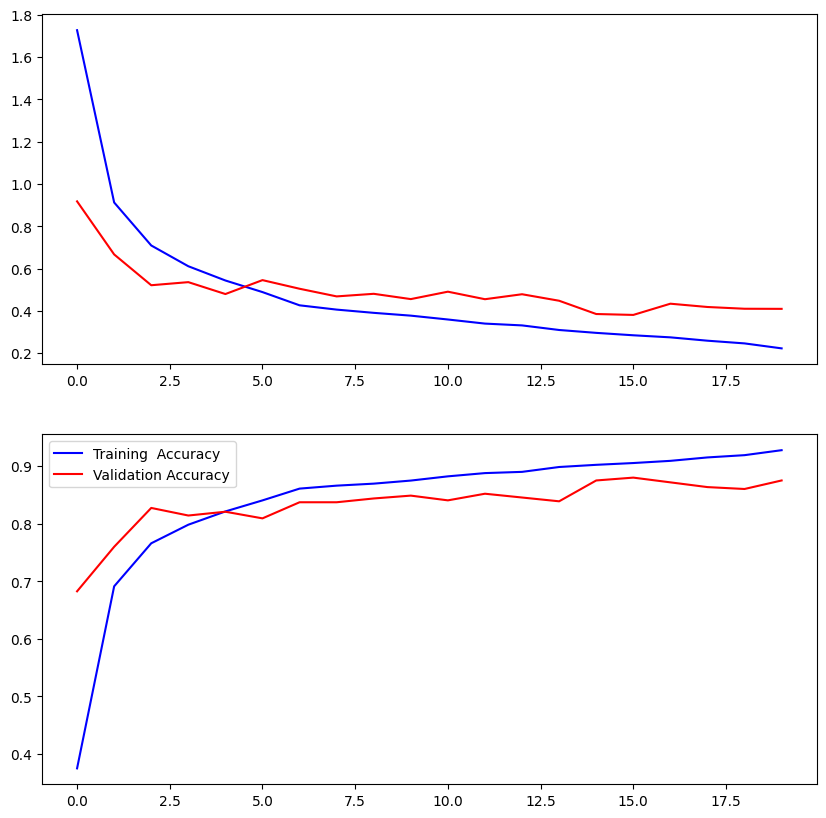

In [18]:
f, ax = plt.subplots(2,1, figsize=(10,10))

ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [20]:
from google.colab import files
files.download('my_model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>